In [1]:
import os
import time
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [46]:
(raw_train, raw_validation, raw_test), metadata = tfds.load('horses_or_humans', split=['train[:80%]', 'train[80%:90%]', 'test[90%:100%]'], with_info=True, as_supervised=True)

In [47]:
get_label_name = metadata.features['label'].int2str

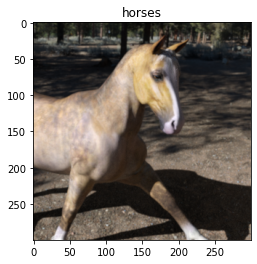

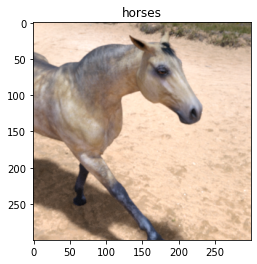

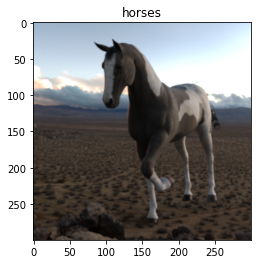

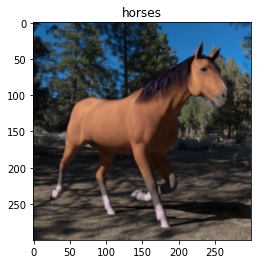

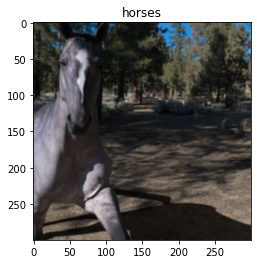

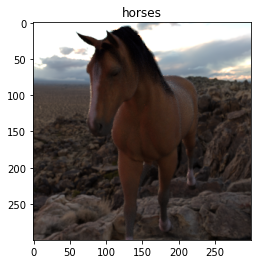

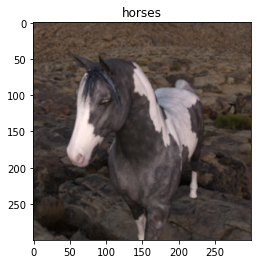

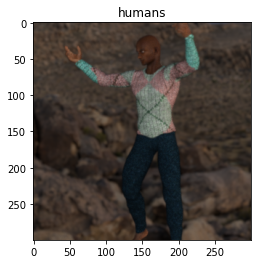

In [ ]:
def show_images(dataset, p):
    for image, label in dataset.take(p):
        plt.figure()
        plt.imshow(image)
        plt.title(get_label_name(label))

show_images(raw_train, 10)

In [49]:
# Resizing img to 160 x 160 as expected by MobileNetV2 inputs
img_size = 160

In [50]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (img_size, img_size))
    
    return image, label

In [51]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [52]:
batch_size = 32
shuffle_bs = 2000
train_batches = train.shuffle(shuffle_bs).batch(batch_size)
validation_batches = validation.batch(batch_size)
test_batches = test.batch(batch_size)

In [58]:
# loading the weights and artchitechture of our base model. We ignore the output layer to replace with ours
img_shape = (img_size, img_size, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                              include_top=False,
                                              weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


In [59]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
__________________________________________________________________________________________________


In [60]:
# Checking the batch shape
for img_batch, lbl_batch in train_batches.take(1):
    pass
print(img_batch.shape, lbl_batch.shape)

(32, 160, 160, 3) (32,)


In [64]:
# MobileNetV2 transforms each 160×160×3 image into a 5×5×1280 block of features
feature_batch = base_model(img_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [73]:
global_average_layer = tf.keras.layers.GlobalAvgPool2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [76]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [77]:
lr = 0.0001
model = tf.keras.Sequential()
model.add(base_model)
model.add(global_average_layer)
model.add(prediction_layer)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=lr), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [78]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [79]:
initial_epochs = 10
r = model.fit(train_batches,
             epochs=initial_epochs,
             validation_data=validation_batches)

Epoch 1/10
26/26 [==============================] - 21s 795ms/step - loss: 5.9823 - accuracy: 0.5243 - val_loss: 2.9527 - val_accuracy: 0.6275
Epoch 2/10
26/26 [==============================] - 20s 750ms/step - loss: 2.7259 - accuracy: 0.6387 - val_loss: 2.2781 - val_accuracy: 0.6863
Epoch 3/10
26/26 [==============================] - 19s 744ms/step - loss: 1.5222 - accuracy: 0.7494 - val_loss: 1.6662 - val_accuracy: 0.7451
Epoch 4/10
26/26 [==============================] - 19s 746ms/step - loss: 0.8617 - accuracy: 0.8260 - val_loss: 1.0421 - val_accuracy: 0.7843
Epoch 5/10
26/26 [==============================] - 20s 780ms/step - loss: 0.4846 - accuracy: 0.8869 - val_loss: 0.8586 - val_accuracy: 0.8039
Epoch 6/10
26/26 [==============================] - 19s 746ms/step - loss: 0.4143 - accuracy: 0.9209 - val_loss: 0.6601 - val_accuracy: 0.8725
Epoch 7/10
26/26 [==============================] - 20s 751ms/step - loss: 0.3469 - accuracy: 0.9355 - val_loss: 0.6056 - val_accuracy: 0.9020